In [61]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import log_loss
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
sns.set_style("whitegrid")
sns.set_palette("Set2", 8)

## Load Data
Define a function that imports all the data from the provided csv files

In [2]:
csv_paths = glob.glob("data/*.csv")
csv_filenames = [os.path.splitext(os.path.basename(x))[0] for x in csv_paths]

def load_data_from_csv():
    """Loads the csv files to pandas DataFrames and saves
    them in a dictionary with their filenames as keys"""
    data = dict()
    for csv_filename, csv_path in zip(csv_filenames, csv_paths):
        data[csv_filename] = pd.read_csv(csv_path)
    return data

# Load the data to a Dictionary
data = load_data_from_csv()

Inspect the data, the schema is shown below:

<img src="docs/schema.png">

First replace the chinese brands with their english names

In [3]:
# Join chinese brand names to their english equivalents
phone_brand_device_model = pd.merge(data["phone_brand_device_model"],
                                    data["chinese_to_english_brand"],
                                    left_on="phone_brand", right_on="chinese_brand", how="left")

# Fill nans for brands already in english
phone_brand_device_model["brand"] =\
    phone_brand_device_model["brand"].where(phone_brand_device_model["brand"].str.isalpha(),
                                                    phone_brand_device_model["phone_brand"].str.lower())

# We will just work with device brand for the time being
device_data = phone_brand_device_model[["device_id", "brand", "device_model"]]
device_data

,device_id,brand,device_model
0,-8890648629457979026,xiaomi,红米
1,1277779817574759137,xiaomi,MI 2
2,5137427614288105724,samsung,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,samsung,Galaxy Note 2
...,...,...,...
187240,7979541072208733273,xiaomi,MI 4
187241,-187404680852357705,xiaomi,红米2
187242,-2718274279595622821,xiaomi,MI 3
187243,3098391762071677791,vivo,X1


Calculate the frequency of each brand and device model in the dataset

In [4]:
print(f'There are {len(device_data["device_id"].unique())} unique devices in the device data')
# Get rid of duplicates in the device data
device_data_cln = device_data.drop_duplicates("device_id")
print(len(device_data_cln))

There are 186716 unique devices in the device data
186716


We'll proceed to join the device brand data to the train data

In [5]:
combined_data = data["gender_age_train"]
print(len(combined_data))
combined_data = pd.merge(combined_data, device_data_cln, on="device_id", how="left")
combined_data

74645


,device_id,gender,age,group,brand,device_model
0,-8076087639492063270,M,35,M32-38,xiaomi,MI 2
1,-2897161552818060146,M,35,M32-38,xiaomi,MI 2
2,-8260683887967679142,M,35,M32-38,xiaomi,MI 2
3,-4938849341048082022,M,30,M29-31,xiaomi,红米note
4,245133531816851882,M,30,M29-31,xiaomi,MI 3
...,...,...,...,...,...,...
74640,4682031842235089751,M,30,M29-31,xiaomi,MI 3
74641,-9178703742877135986,M,30,M29-31,xiaomi,MI 3
74642,180946546684162312,M,20,M22-,xiaomi,红米note
74643,1390702386071991851,M,37,M32-38,huawei,Ascend P8


Count brand and device model names for each gender and then normalise them

In [6]:
total_male = combined_data["gender"].loc[combined_data["gender"]=="M"].count()
total_female = combined_data["gender"].loc[combined_data["gender"]=="F"].count()

In [7]:
brand_counts_gender = combined_data.groupby(["gender", "brand"], as_index=False)[["device_id"]].count().rename(columns={"device_id":"brand_count"})
model_counts_gender = combined_data.groupby(["gender", "device_model"], as_index=False)[["device_id"]].count().rename(columns={"device_id":"model_count"}).drop("gender", axis=1)

In [8]:
device_data = device_data.merge(brand_counts_gender, on="brand", how="left").merge(model_counts_gender, on="device_model", how="left")
device_data

,device_id,brand,device_model,gender,brand_count,model_count
0,-8890648629457979026,xiaomi,红米,F,5918.0,356.0
1,-8890648629457979026,xiaomi,红米,F,5918.0,614.0
2,-8890648629457979026,xiaomi,红米,M,11381.0,356.0
3,-8890648629457979026,xiaomi,红米,M,11381.0,614.0
4,1277779817574759137,xiaomi,MI 2,F,5918.0,150.0
...,...,...,...,...,...,...
743598,3098391762071677791,vivo,X1,M,2986.0,35.0
743599,7540390258631417003,vivo,Y22L,F,2651.0,24.0
743600,7540390258631417003,vivo,Y22L,F,2651.0,31.0
743601,7540390258631417003,vivo,Y22L,M,2986.0,24.0


In [9]:
device_data["brand_count_norm"] = np.where(device_data["gender"]=="M", device_data["brand_count"]/total_male, device_data["brand_count"]/total_female)
device_data["model_count_norm"] = np.where(device_data["gender"]=="M", device_data["model_count"]/total_male, device_data["model_count"]/total_female)

In [10]:
device_data.drop(["brand_count", "model_count"], axis=1, inplace=True)

In [11]:
device_data

,device_id,brand,device_model,gender,brand_count_norm,model_count_norm
0,-8890648629457979026,xiaomi,红米,F,0.221308,0.013313
1,-8890648629457979026,xiaomi,红米,F,0.221308,0.022961
2,-8890648629457979026,xiaomi,红米,M,0.237579,0.007432
3,-8890648629457979026,xiaomi,红米,M,0.237579,0.012817
4,1277779817574759137,xiaomi,MI 2,F,0.221308,0.005609
...,...,...,...,...,...,...
743598,3098391762071677791,vivo,X1,M,0.062333,0.000731
743599,7540390258631417003,vivo,Y22L,F,0.099136,0.000897
743600,7540390258631417003,vivo,Y22L,F,0.099136,0.001159
743601,7540390258631417003,vivo,Y22L,M,0.062333,0.000501


# Event data

In [12]:
# Join app labels to their label categories
app_labels = data["app_labels"].drop_duplicates()
app_labels = app_labels.merge(data["label_categories"], on="label_id")
app_labels

,app_id,label_id,category
0,7324884708820027918,251,Finance
1,-4494216993218550286,251,Finance
2,8756705988821000489,251,Finance
3,1061207043315821111,251,Finance
4,-1491198667294647703,251,Finance
...,...,...,...
459447,-5364349117796323466,985,Word games
459448,6320161160475087425,985,Word games
459449,7641656572760613661,985,Word games
459450,-2037260970074339790,985,Word games


In [13]:
# Join events to their app events
events = data["events"]
events = events.merge(data["app_events"], on="event_id", how="left")

# Use app events to join events to the app labels
events = events.merge(app_labels, on="app_id", how="left")
events.sort_values(by="category")

,event_id,device_id,timestamp,longitude,latitude,app_id,is_installed,is_active,label_id,category
27741865,2545490,2241767092438554986,2016-05-01 06:48:43,119.94,37.17,5.322487e+16,1.0,0.0,714.0,1 free
25742018,2360757,-8892004110917383868,2016-05-06 10:09:48,0.00,0.00,-4.986197e+15,1.0,1.0,714.0,1 free
25741714,2360713,-8642981685332370359,2016-05-06 10:01:40,0.00,0.00,-4.986197e+15,1.0,0.0,714.0,1 free
11596043,1064261,-2613769140653670990,2016-05-05 12:24:46,0.00,0.00,-4.986197e+15,1.0,0.0,714.0,1 free
25739672,2360561,7683263732254566184,2016-05-02 22:54:45,0.00,0.00,5.322487e+16,1.0,0.0,714.0,1 free
...,...,...,...,...,...,...,...,...,...,...
35452563,3252948,7111660304904287709,2016-05-07 23:35:33,121.40,31.18,4.348660e+18,1.0,1.0,NaN,NaN
35452564,3252948,7111660304904287709,2016-05-07 23:35:33,121.40,31.18,-9.957269e+17,1.0,1.0,NaN,NaN
35452565,3252948,7111660304904287709,2016-05-07 23:35:33,121.40,31.18,2.306067e+18,1.0,1.0,NaN,NaN
35452566,3252949,2786044170600788970,2016-05-07 23:36:03,111.19,31.29,NaN,NaN,NaN,NaN,NaN


In [14]:
# Fill nan category values with "unknown"
events["category"].fillna("unknown", inplace=True)
# Fill in missing timestamps with 00:00:00 time
events["timestamp"].fillna("2016-05-01 00:00:00", inplace=True)
# Get time from timestamp object
events['timestamp'] = pd.to_datetime(events['timestamp'])
events["date"] = events['timestamp'].dt.date
events["time"] = events['timestamp'].dt.time
bins = [-0.1, 6, 9, 12, 14, 17, 20, 23]
labels = ["00:00-06:00", "07:00-09:00", "10:00-12:00", "13:00-14:00", "15:00-17:00", "18:00-20:00", "21:00-23:00"]
events["time_group"] = pd.cut(events["timestamp"].dt.hour, bins=bins, labels=labels)

In [15]:
events

,event_id,device_id,timestamp,longitude,latitude,app_id,is_installed,is_active,label_id,category,date,time,time_group
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,NaN,NaN,NaN,NaN,unknown,2016-05-01,00:55:25,00:00-06:00
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,5.927333e+18,1.0,1.0,NaN,unknown,2016-05-01,00:54:12,00:00-06:00
2,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,-5.720079e+18,1.0,0.0,NaN,unknown,2016-05-01,00:54:12,00:00-06:00
3,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,-1.633888e+18,1.0,0.0,NaN,unknown,2016-05-01,00:54:12,00:00-06:00
4,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,-6.531843e+17,1.0,1.0,NaN,unknown,2016-05-01,00:54:12,00:00-06:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35452563,3252948,7111660304904287709,2016-05-07 23:35:33,121.40,31.18,4.348660e+18,1.0,1.0,NaN,unknown,2016-05-07,23:35:33,21:00-23:00
35452564,3252948,7111660304904287709,2016-05-07 23:35:33,121.40,31.18,-9.957269e+17,1.0,1.0,NaN,unknown,2016-05-07,23:35:33,21:00-23:00
35452565,3252948,7111660304904287709,2016-05-07 23:35:33,121.40,31.18,2.306067e+18,1.0,1.0,NaN,unknown,2016-05-07,23:35:33,21:00-23:00
35452566,3252949,2786044170600788970,2016-05-07 23:36:03,111.19,31.29,NaN,NaN,NaN,NaN,unknown,2016-05-07,23:36:03,21:00-23:00


First group by date to get the average installed and active apps per user per session

In [16]:
grouped_events = events.groupby(["device_id", "date"])\
    [["time_group", "is_installed", "is_active", "category"]].agg({"time_group": lambda x: list(set(x)), "is_installed": np.sum, "is_active": np.sum, "category": lambda x: ' '.join(x)}).reset_index()
grouped_events

,device_id,date,time_group,is_installed,is_active,category
0,-9222956879900151005,2016-05-06,"[18:00-20:00, 15:00-17:00, 21:00-23:00]",627.0,292.0,unknown unknown unknown unknown unknown unknow...
1,-9222956879900151005,2016-05-07,"[10:00-12:00, 15:00-17:00, 07:00-09:00, 21:00-...",877.0,418.0,unknown unknown unknown unknown unknown unknow...
2,-9222661944218806987,2016-05-01,"[00:00-06:00, 18:00-20:00]",16.0,11.0,unknown unknown unknown unknown unknown unknow...
3,-9222661944218806987,2016-05-02,[21:00-23:00],7.0,7.0,unknown unknown unknown unknown unknown unknow...
4,-9222661944218806987,2016-05-03,[18:00-20:00],11.0,7.0,unknown unknown unknown unknown unknown unknow...
...,...,...,...,...,...,...
252287,9222110179000857683,2016-05-05,[10:00-12:00],70.0,10.0,unknown unknown unknown unknown unknown unknow...
252288,9222110179000857683,2016-05-06,[18:00-20:00],72.0,6.0,unknown unknown unknown unknown unknown unknow...
252289,9222355582733155698,2016-05-01,[18:00-20:00],67.0,22.0,unknown unknown unknown unknown unknown unknow...
252290,9222355582733155698,2016-05-02,[18:00-20:00],68.0,24.0,unknown unknown unknown unknown unknown unknow...


Aggregate again by device id

In [17]:
# Ignore geographical information for the time being
grouped_events = grouped_events.groupby(["device_id"])\
    [["time_group", "is_installed", "is_active", "category"]].agg({"time_group": np.sum, "is_installed": [np.sum, np.mean], "is_active": [np.sum, np.mean], "category": lambda x: ' '.join(x)}).reset_index()

grouped_events

device_id                                         time_group  \
                                                                          sum   
0     -9222956879900151005  [18:00-20:00, 15:00-17:00, 21:00-23:00, 10:00-...   
1     -9222661944218806987  [00:00-06:00, 18:00-20:00, 21:00-23:00, 18:00-...   
2     -9222399302879214035  [13:00-14:00, 21:00-23:00, 10:00-12:00, 13:00-...   
3     -9221825537663503111  [10:00-12:00, 07:00-09:00, 10:00-12:00, 13:00-...   
4     -9221767098072603291  [13:00-14:00, 15:00-17:00, 13:00-14:00, 00:00-...   
...                    ...                                                ...   
60860  9220914901466458680  [10:00-12:00, 15:00-17:00, 07:00-09:00, 18:00-...   
60861  9221586026451102237  [00:00-06:00, 13:00-14:00, 15:00-17:00, 18:00-...   
60862  9222110179000857683  [10:00-12:00, 10:00-12:00, 10:00-12:00, 18:00-...   
60863  9222355582733155698                         [18:00-20:00, 18:00-20:00]   
60864  9222539910510672930                                      [15:00-17:00]   

      is_installed             is_active              \
               sum        mean       sum        mean   
0           1504.0  752.000000     710.0  355.000000   
1             64.0    9.142857      46.0    6.571429   
2            388.0   97.000000      20.0    5.000000   
3            457.0   76.166667     252.0   42.000000   
4            155.0   31.000000      79.0   15.800000   
...            ...         ...       ...         ...   
60860        857.0  122.428571      88.0   12.571429   
60861        445.0   74.166667      70.0   11.666667   
60862        284.0   71.000000      30.0    7.500000   
60863        135.0   67.500000      46.0   23.000000   
60864         27.0   27.000000       2.0    2.000000   

                                                category  
                                                <lambda>  
0      unknown unknown unknown unknown unknown unknow...  
1      unknown unknown unknown unknown unknown unknow...  
2      unknown unknown unknown unknown unknown unknow...  
3      unknown unknown unknown unknown unknown unknow...  
4      unknown unknown unknown unknown unknown unknow...  
...                                                  ...  
60860  Property Industry 1.0 Industry tag Personal Ef...  
60861  unknown unknown unknown unknown unknown unknow...  
60862  unknown unknown unknown unknown unknown unknow...  
60863  unknown unknown unknown unknown unknown unknow...  
60864  unknown unknown unknown unknown unknown unknow...  

[60865 rows x 7 columns]

In [18]:
grouped_events["time_group"] = grouped_events["time_group"]["sum"].apply(lambda x: list(set(x)))

In [19]:
grouped_events

device_id                                         time_group  \
                                                                          sum   
0     -9222956879900151005  [10:00-12:00, 15:00-17:00, 07:00-09:00, 18:00-...   
1     -9222661944218806987            [00:00-06:00, 18:00-20:00, 21:00-23:00]   
2     -9222399302879214035            [10:00-12:00, 13:00-14:00, 21:00-23:00]   
3     -9221825537663503111  [10:00-12:00, 07:00-09:00, 18:00-20:00, 21:00-...   
4     -9221767098072603291  [10:00-12:00, 15:00-17:00, 07:00-09:00, 18:00-...   
...                    ...                                                ...   
60860  9220914901466458680  [10:00-12:00, 15:00-17:00, 07:00-09:00, 18:00-...   
60861  9221586026451102237  [10:00-12:00, 15:00-17:00, 07:00-09:00, 18:00-...   
60862  9222110179000857683                         [10:00-12:00, 18:00-20:00]   
60863  9222355582733155698                                      [18:00-20:00]   
60864  9222539910510672930                                      [15:00-17:00]   

      is_installed             is_active              \
               sum        mean       sum        mean   
0           1504.0  752.000000     710.0  355.000000   
1             64.0    9.142857      46.0    6.571429   
2            388.0   97.000000      20.0    5.000000   
3            457.0   76.166667     252.0   42.000000   
4            155.0   31.000000      79.0   15.800000   
...            ...         ...       ...         ...   
60860        857.0  122.428571      88.0   12.571429   
60861        445.0   74.166667      70.0   11.666667   
60862        284.0   71.000000      30.0    7.500000   
60863        135.0   67.500000      46.0   23.000000   
60864         27.0   27.000000       2.0    2.000000   

                                                category  
                                                <lambda>  
0      unknown unknown unknown unknown unknown unknow...  
1      unknown unknown unknown unknown unknown unknow...  
2      unknown unknown unknown unknown unknown unknow...  
3      unknown unknown unknown unknown unknown unknow...  
4      unknown unknown unknown unknown unknown unknow...  
...                                                  ...  
60860  Property Industry 1.0 Industry tag Personal Ef...  
60861  unknown unknown unknown unknown unknown unknow...  
60862  unknown unknown unknown unknown unknown unknow...  
60863  unknown unknown unknown unknown unknown unknow...  
60864  unknown unknown unknown unknown unknown unknow...  

[60865 rows x 7 columns]

In [20]:
grouped_events.columns = grouped_events.columns.droplevel(1)
grouped_events.columns = ["device_id", "time_group", "is_installed_sum", "is_installed_mean", "is_active_sum", "is_active_mean", "category"]
grouped_events

,device_id,time_group,is_installed_sum,is_installed_mean,is_active_sum,is_active_mean,category
0,-9222956879900151005,"[10:00-12:00, 15:00-17:00, 07:00-09:00, 18:00-...",1504.0,752.000000,710.0,355.000000,unknown unknown unknown unknown unknown unknow...
1,-9222661944218806987,"[00:00-06:00, 18:00-20:00, 21:00-23:00]",64.0,9.142857,46.0,6.571429,unknown unknown unknown unknown unknown unknow...
2,-9222399302879214035,"[10:00-12:00, 13:00-14:00, 21:00-23:00]",388.0,97.000000,20.0,5.000000,unknown unknown unknown unknown unknown unknow...
3,-9221825537663503111,"[10:00-12:00, 07:00-09:00, 18:00-20:00, 21:00-...",457.0,76.166667,252.0,42.000000,unknown unknown unknown unknown unknown unknow...
4,-9221767098072603291,"[10:00-12:00, 15:00-17:00, 07:00-09:00, 18:00-...",155.0,31.000000,79.0,15.800000,unknown unknown unknown unknown unknown unknow...
...,...,...,...,...,...,...,...
60860,9220914901466458680,"[10:00-12:00, 15:00-17:00, 07:00-09:00, 18:00-...",857.0,122.428571,88.0,12.571429,Property Industry 1.0 Industry tag Personal Ef...
60861,9221586026451102237,"[10:00-12:00, 15:00-17:00, 07:00-09:00, 18:00-...",445.0,74.166667,70.0,11.666667,unknown unknown unknown unknown unknown unknow...
60862,9222110179000857683,"[10:00-12:00, 18:00-20:00]",284.0,71.000000,30.0,7.500000,unknown unknown unknown unknown unknown unknow...
60863,9222355582733155698,[18:00-20:00],135.0,67.500000,46.0,23.000000,unknown unknown unknown unknown unknown unknow...


Proceed to join the device event data to the train data

In [21]:
combined_data = pd.merge(combined_data, grouped_events, on="device_id", how="left")
combined_data.sort_values(by="brand")

,device_id,gender,age,group,brand,device_model,time_group,is_installed_sum,is_installed_mean,is_active_sum,is_active_mean,category
6085,-231815432814429273,M,28,M27-28,AUX,V965T,NaN,NaN,NaN,NaN,NaN,NaN
31531,8567026160899753334,F,41,F33-42,AUX,V965T,NaN,NaN,NaN,NaN,NaN,NaN
54106,5489607796787403797,F,43,F43+,AUX,V965T,NaN,NaN,NaN,NaN,NaN,NaN
38470,-4567000646686758042,M,63,M39+,AUX,V965T,NaN,NaN,NaN,NaN,NaN,NaN
60798,4844629161497691306,M,40,M39+,Bacardi,V6,"[10:00-12:00, 18:00-20:00, 07:00-09:00, 13:00-...",408.0,102.0,102.0,25.5,unknown unknown Property Industry 1.0 Industry...
...,...,...,...,...,...,...,...,...,...,...,...,...
57155,8109205969894662857,M,40,M39+,飞利浦,W6618,NaN,NaN,NaN,NaN,NaN,NaN
28536,6588287214961767693,F,31,F29-32,首云,P1,NaN,NaN,NaN,NaN,NaN,NaN
63421,-1527969048433963834,M,34,M32-38,首云,P1,NaN,NaN,NaN,NaN,NaN,NaN
62833,-6193284194987082936,F,29,F29-32,首云,P1,NaN,NaN,NaN,NaN,NaN,NaN


Add a column for the devices that event data are available

In [22]:
combined_data["event_data"] = np.where(combined_data["category"].isna(), 0, 1)

Fill remaining missing values

In [23]:
combined_data.fillna({"is_installed_sum":0, "is_installed_mean":0, "is_active_sum":0, "is_active_mean":0}, inplace=True)
combined_data["category"].fillna("unknown", inplace=True)
combined_data["time_group"].fillna("unknown", inplace=True)
combined_data["time_group"].loc[combined_data["time_group"]=="unknown"] = combined_data["time_group"].loc[combined_data["time_group"]=="unknown"].apply(lambda x: [x])

C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [24]:
combined_data

,device_id,gender,age,group,brand,device_model,time_group,is_installed_sum,is_installed_mean,is_active_sum,is_active_mean,category,event_data
0,-8076087639492063270,M,35,M32-38,xiaomi,MI 2,[unknown],0.0,0.0,0.0,0.0,unknown,0
1,-2897161552818060146,M,35,M32-38,xiaomi,MI 2,[unknown],0.0,0.0,0.0,0.0,unknown,0
2,-8260683887967679142,M,35,M32-38,xiaomi,MI 2,[13:00-14:00],53.0,53.0,6.0,6.0,unknown unknown unknown unknown unknown unknow...,1
3,-4938849341048082022,M,30,M29-31,xiaomi,红米note,[unknown],0.0,0.0,0.0,0.0,unknown,0
4,245133531816851882,M,30,M29-31,xiaomi,MI 3,[unknown],0.0,0.0,0.0,0.0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74640,4682031842235089751,M,30,M29-31,xiaomi,MI 3,[unknown],0.0,0.0,0.0,0.0,unknown,0
74641,-9178703742877135986,M,30,M29-31,xiaomi,MI 3,[unknown],0.0,0.0,0.0,0.0,unknown,0
74642,180946546684162312,M,20,M22-,xiaomi,红米note,[unknown],0.0,0.0,0.0,0.0,unknown,0
74643,1390702386071991851,M,37,M32-38,huawei,Ascend P8,[15:00-17:00],43.0,43.0,2.0,2.0,unknown unknown unknown unknown unknown unknow...,1


In [25]:
grouped_events.sort_values(by="time_group")

,device_id,time_group,is_installed_sum,is_installed_mean,is_active_sum,is_active_mean,category
13864,-5065417798621313929,[00:00-06:00],64.0,64.0,1.0,1.00,unknown unknown unknown unknown unknown unknow...
41065,3225324755742672993,[00:00-06:00],11.0,11.0,6.0,6.00,unknown unknown unknown unknown unknown unknow...
28966,-461266604811288576,[00:00-06:00],80.0,40.0,19.0,9.50,unknown unknown unknown unknown unknown unknow...
41066,3225387445500784964,[00:00-06:00],68.0,68.0,2.0,2.00,unknown unknown unknown unknown unknown unknow...
60620,9152377803056856982,[00:00-06:00],21.0,21.0,10.0,10.00,unknown unknown unknown unknown unknown unknow...
...,...,...,...,...,...,...,...
23070,-2282486665211484319,[21:00-23:00],18.0,9.0,14.0,7.00,unknown unknown unknown unknown unknown unknow...
23064,-2284803913977390006,[21:00-23:00],26.0,26.0,13.0,13.00,unknown unknown unknown unknown unknown unknow...
56798,8010682914051497220,[21:00-23:00],438.0,109.5,147.0,36.75,unknown unknown unknown unknown unknown unknow...
23574,-2130483853436320830,[21:00-23:00],29.0,29.0,17.0,17.00,unknown unknown unknown unknown unknown unknow...


In [26]:
mlb = MultiLabelBinarizer(sparse_output=True)

combined_data = combined_data.join(pd.DataFrame.sparse.from_spmatrix(
                                    mlb.fit_transform(combined_data.pop("time_group")),
                                    index=combined_data.index,
                                    columns="time_group_"+mlb.classes_))

In [27]:
combined_data

,device_id,gender,age,group,brand,device_model,is_installed_sum,is_installed_mean,is_active_sum,is_active_mean,category,event_data,time_group_00:00-06:00,time_group_07:00-09:00,time_group_10:00-12:00,time_group_13:00-14:00,time_group_15:00-17:00,time_group_18:00-20:00,time_group_21:00-23:00,time_group_unknown
0,-8076087639492063270,M,35,M32-38,xiaomi,MI 2,0.0,0.0,0.0,0.0,unknown,0,0,0,0,0,0,0,0,1
1,-2897161552818060146,M,35,M32-38,xiaomi,MI 2,0.0,0.0,0.0,0.0,unknown,0,0,0,0,0,0,0,0,1
2,-8260683887967679142,M,35,M32-38,xiaomi,MI 2,53.0,53.0,6.0,6.0,unknown unknown unknown unknown unknown unknow...,1,0,0,0,1,0,0,0,0
3,-4938849341048082022,M,30,M29-31,xiaomi,红米note,0.0,0.0,0.0,0.0,unknown,0,0,0,0,0,0,0,0,1
4,245133531816851882,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,unknown,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74640,4682031842235089751,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,unknown,0,0,0,0,0,0,0,0,1
74641,-9178703742877135986,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,unknown,0,0,0,0,0,0,0,0,1
74642,180946546684162312,M,20,M22-,xiaomi,红米note,0.0,0.0,0.0,0.0,unknown,0,0,0,0,0,0,0,0,1
74643,1390702386071991851,M,37,M32-38,huawei,Ascend P8,43.0,43.0,2.0,2.0,unknown unknown unknown unknown unknown unknow...,1,0,0,0,0,1,0,0,0


In [28]:
vectoriser = TfidfVectorizer(min_df=1)
vectors = vectoriser.fit_transform(grouped_events["category"])

feature_names = vectoriser.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [29]:
combined_data = combined_data.join(pd.DataFrame.sparse.from_spmatrix(
                                    vectoriser.fit_transform(combined_data.pop("category")),
                                    index=combined_data.index,
                                    columns=["category_"+x for x in vectoriser.get_feature_names()]))

In [30]:
combined_data

,device_id,gender,age,group,brand,device_model,is_installed_sum,is_installed_mean,is_active_sum,is_active_mean,...,category_utilities,category_vehicles,category_video,category_vitality,category_wars,category_wealth,category_weight,category_west,category_with,category_zombies
0,-8076087639492063270,M,35,M32-38,xiaomi,MI 2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2897161552818060146,M,35,M32-38,xiaomi,MI 2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-8260683887967679142,M,35,M32-38,xiaomi,MI 2,53.0,53.0,6.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-4938849341048082022,M,30,M29-31,xiaomi,红米note,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,245133531816851882,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74640,4682031842235089751,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74641,-9178703742877135986,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74642,180946546684162312,M,20,M22-,xiaomi,红米note,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74643,1390702386071991851,M,37,M32-38,huawei,Ascend P8,43.0,43.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Device brand
phoneencoder = LabelEncoder().fit(combined_data["brand"] + " " + combined_data["device_model"])

combined_data['phone'] = phoneencoder.transform(combined_data["brand"] + " " + combined_data["device_model"])


In [32]:
combined_data

,device_id,gender,age,group,brand,device_model,is_installed_sum,is_installed_mean,is_active_sum,is_active_mean,...,category_vehicles,category_video,category_vitality,category_wars,category_wealth,category_weight,category_west,category_with,category_zombies,phone
0,-8076087639492063270,M,35,M32-38,xiaomi,MI 2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1400
1,-2897161552818060146,M,35,M32-38,xiaomi,MI 2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1400
2,-8260683887967679142,M,35,M32-38,xiaomi,MI 2,53.0,53.0,6.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1400
3,-4938849341048082022,M,30,M29-31,xiaomi,红米note,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1422
4,245133531816851882,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74640,4682031842235089751,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1404
74641,-9178703742877135986,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1404
74642,180946546684162312,M,20,M22-,xiaomi,红米note,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1422
74643,1390702386071991851,M,37,M32-38,huawei,Ascend P8,43.0,43.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,766


In [33]:
combined_data = combined_data.join(pd.get_dummies(combined_data['phone'], prefix='phone_', prefix_sep=''))

In [34]:
combined_data

,device_id,gender,age,group,brand,device_model,is_installed_sum,is_installed_mean,is_active_sum,is_active_mean,...,phone_1476,phone_1477,phone_1478,phone_1479,phone_1480,phone_1481,phone_1482,phone_1483,phone_1484,phone_1485
0,-8076087639492063270,M,35,M32-38,xiaomi,MI 2,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,-2897161552818060146,M,35,M32-38,xiaomi,MI 2,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,-8260683887967679142,M,35,M32-38,xiaomi,MI 2,53.0,53.0,6.0,6.0,...,0,0,0,0,0,0,0,0,0,0
3,-4938849341048082022,M,30,M29-31,xiaomi,红米note,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,245133531816851882,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74640,4682031842235089751,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
74641,-9178703742877135986,M,30,M29-31,xiaomi,MI 3,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
74642,180946546684162312,M,20,M22-,xiaomi,红米note,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
74643,1390702386071991851,M,37,M32-38,huawei,Ascend P8,43.0,43.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0


# Approach 1

In [35]:
LABELS = ["group"]
NON_FEATURE_COLUMNS = ["device_id", "gender", "age", "group", "brand", "device_model", "event_data"]

In [36]:
# Prepare the labels
y = combined_data[LABELS]
y = pd.get_dummies(y, prefix='', prefix_sep='')
y_enc = y.to_numpy()
y_enc

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [37]:
# Prepare the features
X = combined_data.drop(NON_FEATURE_COLUMNS, axis=1)
X_enc = X.to_numpy()
X_enc

array([[  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
       [ 53. ,  53. ,   6. , ...,   0. ,   0. ,   0. ],
       ...,
       [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
       [ 43. ,  43. ,   2. , ...,   0. ,   0. ,   0. ],
       [143. ,  28.6,  12. , ...,   0. ,   0. ,   0. ]])

In [38]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=combined_data["event_data"], random_state=1)
# Split into train set further into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [46]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(12, activation="softmax", input_shape=(1687,)),  # input shape required
])

In [47]:
predictions = model(X_train)
predictions[:5]

<tf.Tensor: shape=(5, 12), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.3522434e-29,
        0.0000000e+00, 9.9999523e-01, 4.6040732e-13, 1.0761728e-26,
        3.8530551e-19, 4.7978710e-06, 1.8017880e-13, 0.0000000e+00],
       [2.2877777e-29, 1.7606125e-33, 1.4498311e-27, 5.7050339e-23,
        3.0738577e-30, 1.3380514e-01, 1.4960608e-10, 4.9193703e-19,
        8.4847664e-11, 8.6619490e-01, 2.4846589e-09, 9.7465465e-31],
       [0.0000000e+00, 0.0000000e+00, 9.7949126e-38, 5.6083019e-34,
        0.0000000e+00, 5.3060733e-02, 3.0529001e-15, 5.9621504e-28,
        3.4881061e-14, 9.4693923e-01, 6.8867919e-14, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.3119035e-32,
        0.0000000e+00, 9.9999857e-01, 2.6639344e-14, 3.5109179e-29,
        6.6557198e-21, 1.4797083e-06, 1.0831063e-14, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.9832525e-38,
        0.0000000e+00, 9.9999988e-01, 9.2881510e-17, 2.1133322e

In [48]:
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [49]:
history = model.fit(X_train, y_train, epochs=60, verbose=1, validation_data=(X_val, y_val))

Epoch 1/60
1400/1400 [==============================] - 2s 2ms/step - loss: 3.8380 - accuracy: 0.1036 - val_loss: 3.4143 - val_accuracy: 0.0699
Epoch 2/60
1400/1400 [==============================] - 2s 2ms/step - loss: 2.9396 - accuracy: 0.1090 - val_loss: 3.2034 - val_accuracy: 0.0771
Epoch 3/60
1400/1400 [==============================] - 3s 2ms/step - loss: 2.9200 - accuracy: 0.1144 - val_loss: 3.0006 - val_accuracy: 0.1308
Epoch 4/60
1400/1400 [==============================] - 2s 2ms/step - loss: 2.9068 - accuracy: 0.1157 - val_loss: 2.6685 - val_accuracy: 0.1398
Epoch 5/60
1400/1400 [==============================] - 2s 2ms/step - loss: 2.8944 - accuracy: 0.1207 - val_loss: 3.2955 - val_accuracy: 0.0818
Epoch 6/60
1400/1400 [==============================] - 2s 2ms/step - loss: 2.9120 - accuracy: 0.1225 - val_loss: 3.2133 - val_accuracy: 0.1335
Epoch 7/60
1400/1400 [==============================] - 2s 2ms/step - loss: 2.8806 - accuracy: 0.1252 - val_loss: 2.8009 - val_accuracy:

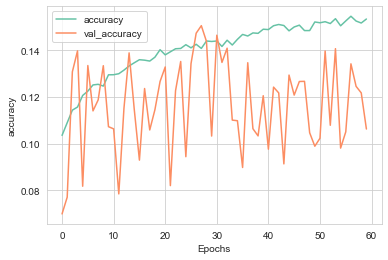

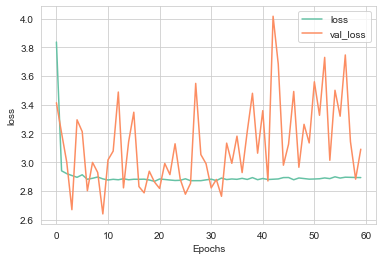

In [50]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_"+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Approach 2

In [54]:
# Device brand
encoder = LabelEncoder().fit(combined_data["group"])
y_lin = encoder.transform(combined_data["group"])
y_lin

array([10, 10, 10, ...,  6, 10,  7])

In [56]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_lin, test_size=0.2, stratify=combined_data["event_data"], random_state=1)
# Split into train set further into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [57]:
from sklearn.linear_model import LogisticRegression

# Logistic regression
clf1 = LogisticRegression(C=0.06, multi_class='multinomial', solver='lbfgs')
# Fitting logistic regression
clf1.fit(X_train, y_train)

C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.06, multi_class='multinomial')

In [58]:
pred = clf1.predict_proba(X_train)

C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:508: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [59]:
pred

array([[0.07042656, 0.06247284, 0.04500182, ..., 0.09496857, 0.11748131,
        0.10649758],
       [0.06987765, 0.04989319, 0.04332513, ..., 0.11014688, 0.13229964,
        0.10156398],
       [0.05965134, 0.04278963, 0.03425597, ..., 0.11341831, 0.14659056,
        0.11114946],
       ...,
       [0.0684947 , 0.05982651, 0.04130417, ..., 0.09601399, 0.12208838,
        0.10927769],
       [0.07318015, 0.06639877, 0.05090206, ..., 0.09323614, 0.11078627,
        0.10231712],
       [0.07904624, 0.07239151, 0.06569912, ..., 0.0909917 , 0.09935127,
        0.09243346]])

In [63]:
score_val = log_loss(y_train, pred)
score_val

2.430516564043606

In [68]:
score_val = log_loss(y_train, tf.nn.softmax(predictions))
score_val

2.5504600963517574

# Approach 3

In [79]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=combined_data["event_data"], random_state=1)
# Split into train set further into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [83]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dropout(0.4, input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(75))
model.add(tf.keras.layers.PReLU())
model.add(tf.keras.layers.Dropout(0.30))
model.add(tf.keras.layers.Dense(50, activation="tanh"))
model.add(tf.keras.layers.PReLU())
model.add(tf.keras.layers.Dropout(0.20))

model.add(tf.keras.layers.Dense(12, activation="softmax"))
    
# Compile model
model.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])

In [84]:
history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_val, y_val))

Epoch 1/100
1400/1400 [==============================] - 4s 3ms/step - loss: 2.8300 - accuracy: 0.0864 - val_loss: 3.0454 - val_accuracy: 0.0995
Epoch 2/100
1400/1400 [==============================] - 4s 3ms/step - loss: 2.8107 - accuracy: 0.0889 - val_loss: 3.0063 - val_accuracy: 0.0996
Epoch 3/100
1400/1400 [==============================] - 4s 3ms/step - loss: 2.7903 - accuracy: 0.0894 - val_loss: 2.9578 - val_accuracy: 0.0994
Epoch 4/100
1400/1400 [==============================] - 4s 3ms/step - loss: 2.7755 - accuracy: 0.0898 - val_loss: 2.8991 - val_accuracy: 0.0991
Epoch 5/100
1400/1400 [==============================] - 3s 2ms/step - loss: 2.7559 - accuracy: 0.0937 - val_loss: 2.8390 - val_accuracy: 0.0990
Epoch 6/100
1400/1400 [==============================] - 4s 3ms/step - loss: 2.7467 - accuracy: 0.0904 - val_loss: 2.8156 - val_accuracy: 0.0992
Epoch 7/100
1400/1400 [==============================] - 4s 3ms/step - loss: 2.7255 - accuracy: 0.0940 - val_loss: 2.7936 - val_ac

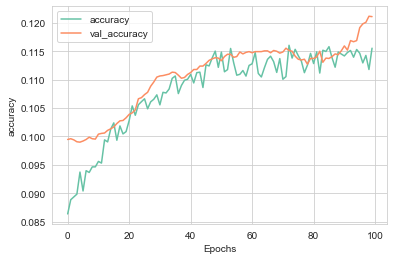

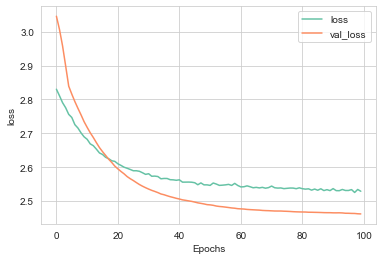

In [85]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [87]:
predictions = model(X_train)
score_val = log_loss(y_train, tf.nn.softmax(predictions))
score_val

2.4754915352518405